## Improting Dependencies

In [1]:
import mne
import matplotlib.pyplot as plt
import glob
import numpy as np

## Configuring required settings

In [2]:
# Setting backend frackwork as matplotlib for ploting
mne.viz.set_browser_backend("matplotlib")

Using matplotlib as 2D backend.


In [3]:
# Enabling CUDA
mne.utils.set_config('MNE_USE_CUDA', 'true')

## Reading Dataset
We are reading four different kinds of datasets depicting 
- Heartfulness Meditation (htr)
- Concentration Meditation (ctr)
- Vipassana Meditation (vip)
- Sahaja Yoga Meditation (sny)

respectively.

In [4]:
%%capture
# To avoid unneccesary writing

raw_data  =[]

# Types of data (for task-wise analysis)
data_we_need = ['015', '033', '079', '080']

# Getting data for task-wise analysis
for subject_number in data_we_need:
    for file in sorted(glob.glob('../sub-'+subject_number+'/eeg/*.bdf')):
        try:            
            data = mne.io.read_raw_bdf(file, preload=True)
            times = data.times
            duration = times[-1] - times[0]
            # Getting only data greater than or equal to 10 minutes
            if duration >= 600:
                raw_data.append(data)
                print("Appended")
        except:
            print(file +" not loaded")

med1 = [0, 4, 8, 12]
med2 = [1, 5, 9, 13]
think1 = [2, 6, 10, 14]
think2 = [3, 7, 11, 15]

## Preprocessing Data
In this process, we will extract the necessary duration of data required and perform data cleaning to remove any artifacts.
- Dropping unnecessary channels
- Referencing Data
- Cropping data
- Downsampling data
- Filtering data (notch filter and bandpass filter)
- Applying ICA

In [5]:
# Dropping Channels
channels_to_drop = ['EXG1', 'EXG2', 'EXG3', 'EXG4',
        'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp',
       'Plet', 'Temp', 'Status']
for data in raw_data:
    for channel in channels_to_drop:
        if channel in data.ch_names:
            data.drop_channels([channel])

In [6]:
%%capture

# Referencing data (To apply_inverse for source localization)
raw_data  = [data.set_eeg_reference(projection=True) for data in raw_data]

In [7]:
# Croping Data 
# Considering only first 10 minutes
cropped_raw_data = []

for files in raw_data:
    cropped_raw_data.append(files.crop(tmin=0.0, tmax=600.0))

In [8]:
%%capture

# Downsampling data to 256 Hz
raw_resampled = [raw_data.copy().resample(sfreq=256, npad="auto", n_jobs="cuda") for raw_data in cropped_raw_data]

In [9]:
# Preprocessing
# Cleaning the entire EEG 
def get_filtered_eeg(raw):
    low_freq = 0.3
    high_freq = 100.0

    raw_filtered = raw.copy().notch_filter(freqs=50)

    # Apply the bandpass filter
    raw_filtered = raw_filtered.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin', n_jobs="cuda")

    #ASR cleaning with cutoff=20
    # asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=20)
    # asr.fit(raw_filtered)
    # raw_filtered = asr.transform(raw_filtered)

    ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", random_state=97)
    ica.fit(raw_filtered)

    # # ica.plot_components()

    ica.exclude = []
    # find which ICs match the EOG pattern; no EOG attached, Taking Fp1 as proxy
    eog_indices, eog_scores = ica.find_bads_eog(raw_filtered,ch_name="Fp1")
    ica.exclude = eog_indices
    ica.apply(raw_filtered)
    return raw_filtered

In [10]:
%%capture

# Filtering data
filtered_data = []

for data in raw_resampled:
    filtered_data.append(get_filtered_eeg(data))

## Power Spectral Density(PSD)
- Will compute PSD
- Removing Pink noise from it

In [11]:
%%capture

# Computing PSD data for whole mediation 1 data
psdDatas, psdFreqs = [],  []
for i in med1:
    psdData, psdFreq = filtered_data[i].compute_psd(fmin=2, fmax=110, picks=['Oz']).get_data(return_freqs = True)
    psdDatas.append(psdData)
    psdFreqs.append(psdFreq)

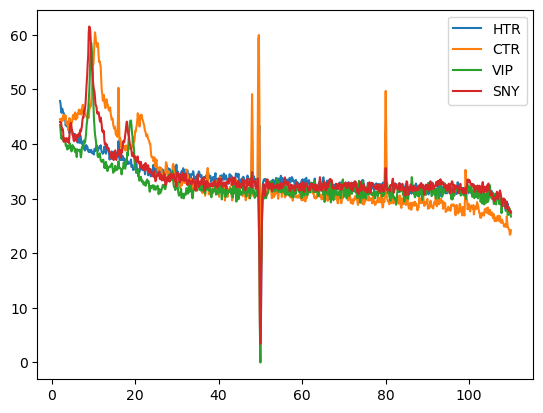

In [12]:
plt.clf()

# To get whole positive graph
shift_med1 = np.min([np.min(10*np.log10(psdDatas[0][0])), np.min(10*np.log10(psdDatas[1][0])), np.min(10*np.log10(psdDatas[2][0])), np.min(10*np.log10(psdDatas[3][0]))])

# Plotting all plots
# Converting to dB and referencing for positive graph
plt.plot(psdFreq, 10*np.log10(psdDatas[0][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[1][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[2][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[3][0]) - shift_med1);
plt.legend([
    'HTR',
    'CTR',
    'VIP',
    'SNY'
])
plt.show();

In [13]:
# Power law for removing pink noise
def power_law(x, a, b):
    return a * (x ** (-b))

<Figure size 640x480 with 0 Axes>

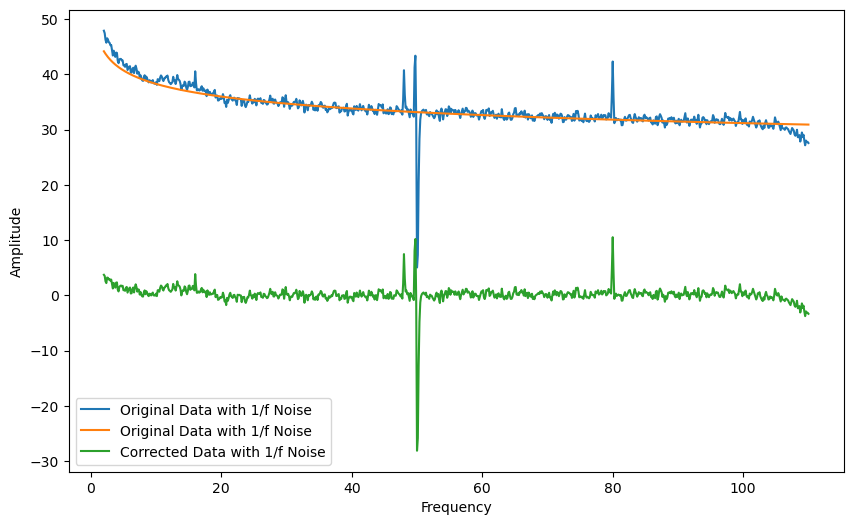

In [14]:
from scipy.optimize import curve_fit

# Select the tail region for fitting
tail_fraction = 0.6
tail_start_index = int((1 - tail_fraction) * len(psdFreqs[0]))

# Getting tail
x_tail = psdFreqs[0][tail_start_index:]
y_tail = (10*np.log10(psdDatas[0][0]) - shift_med1)[tail_start_index:]

# Fitting a curve to tail
popt, _ = curve_fit(power_law, x_tail, y_tail)
a, b = popt

y_fit = power_law(psdFreqs[0], a, b)

# # Plot the fitted curve on top of the original data
plt.clf()
plt.figure(figsize=(10, 6))
plt.plot(psdFreq, 10*np.log10(psdDatas[0][0]) - shift_med1, label='Original Data with 1/f Noise');
plt.plot(psdFreq, y_fit, label='Original Data with 1/f Noise');
plt.plot(psdFreq, 10*np.log10(psdDatas[0][0]) - shift_med1 - y_fit, label='Corrected Data with 1/f Noise');
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.show();


<Figure size 640x480 with 0 Axes>

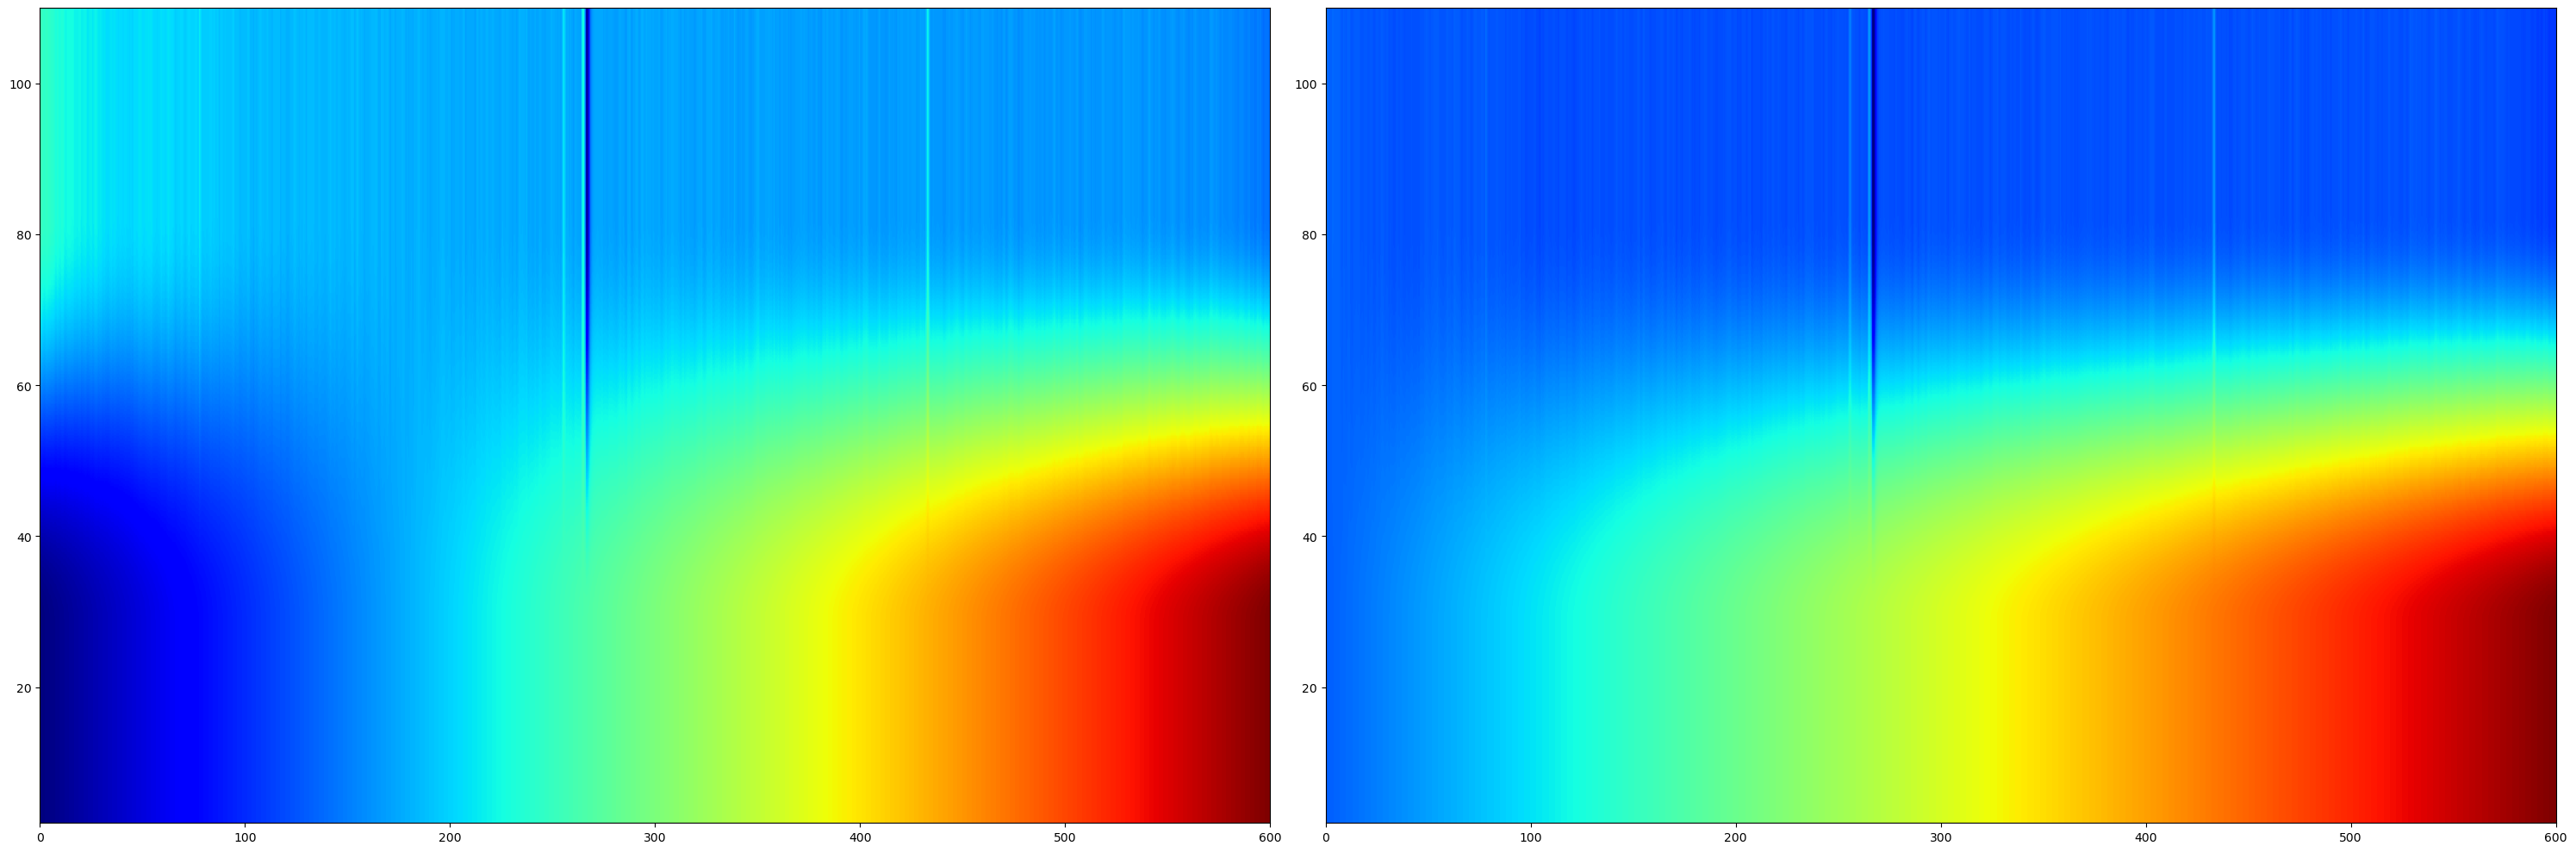

In [15]:
# Ploting power spectrum
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10));
im1 = ax1.imshow((psdFreqs[0], (10*np.log10(psdDatas[0][0]) - shift_med1)),origin='lower', aspect='auto', extent=[0, 600, 2, 110], cmap='jet');
im2 = ax2.imshow((psdFreqs[0], 10*np.log10(psdDatas[0][0]) - shift_med1 - y_fit),origin='lower', aspect='auto', extent=[0, 600, 2, 110], cmap='jet');
plt.tight_layout()
plt.show()

## Connectivity

We will use med2 and think2 data:
- Creating fake epochs as we don't have stimulus channel in the data
- Using standard head model as we don't have MEG data 

In [16]:
from mne_connectivity import spectral_connectivity_epochs

In [17]:
# Creating fake epochs
# Define parameters
epoch_length = 10.0  # in seconds
overlap = 0.5  # in seconds
sfreq = filtered_data[0].info['sfreq']  # sampling frequency
epoch_samples = int(epoch_length * sfreq)
overlap_samples = int(overlap * sfreq)

# Calculate the number of epochs
n_epochs = int((len(filtered_data[0]) - overlap_samples) / (epoch_samples - overlap_samples))

# Generate events
events = np.array([[i * (epoch_samples - overlap_samples), 0, 1] for i in range(n_epochs)])

In [18]:
data_we_need = [filtered_data[i] for i in med2 + think2]

In [19]:
%%capture

# Create epochs
epochs = [mne.Epochs(data, events, event_id=1, tmin=0, tmax=epoch_length, baseline=None, preload=True) for data in data_we_need]

In [20]:
# Use standard head model
import os.path as op
from mne.datasets import fetch_fsaverage

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files
subject = "fsaverage"
trans = "fsaverage"
src = op.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")
bem = op.join(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")

0 files missing from root.txt in /home/server/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/server/mne_data/MNE-fsaverage-data/fsaverage


### For Med2

In [21]:
%%capture

# Set standard montage to assign EEG locations
montage = mne.channels.make_standard_montage('standard_1005')
for data in data_we_need:
    data.set_montage(montage)

# Compute forward solution
fwd = [mne.make_forward_solution(
    data.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=None
) for data in data_we_need]
print(fwd)

In [22]:

# BEM and source spaces
bem_dir = op.join(subjects_dir, subject, "bem")
fname_src = op.join(bem_dir, f"{subject}-ico-5-src.fif")

src = mne.read_source_spaces(fname_src)
print(src)
fname_bem = op.join(bem_dir, f"{subject}-5120-5120-5120-bem-sol.fif")
bem = mne.read_bem_solution(fname_bem)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
<SourceSpaces: [<surface (lh), n_vertices=163842, n_used=10242>, <surface (rh), n_vertices=163842, n_used=10242>] MRI (surface RAS) coords, subject 'fsaverage', ~21.9 MB>
Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /home/server/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif


In [41]:
# Getting labels
# Get labels (anatomical regions defined on cortical surface of brain) for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot("fsaverage", parc="aparc", subjects_dir=subjects_dir)
label_colors = [label.color for label in labels]
#The code is something like the following
labels = [i for i in labels if 'unknown' not in i.name]
# Getting coordinates of labels
region_coordinates = []
for label in labels:
    region_coordinates.append(mne.vertex_to_mni(label.center_of_mass(subject=subject), 0 if label.hemi=='lh' else 1, subject=subject))

region_coordinates

Reading labels from parcellation...
   read 35 labels from /home/server/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /home/server/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot


[array([-49.08287048, -43.74771881,   4.03976774]),
 array([ 44.97354889, -39.53186798,   6.7096734 ]),
 array([-5.06507111, 19.15657043, 26.37181664]),
 array([ 5.71848822, 19.71026993, 26.58016396]),
 array([-40.71143341,  14.64152241,  48.5267334 ]),
 array([41.61339569, 15.69366646, 47.75548553]),
 array([ -3.70997739, -76.28938293,  20.17150116]),
 array([  4.25271082, -79.0639267 ,  21.82949638]),
 array([-23.54651451,  -7.39666605, -33.48207092]),
 array([ 24.76414871,  -6.04600239, -33.70613861]),
 array([-7.9999032 , 63.14669037, -8.53275013]),
 array([  8.72715187,  62.69087982, -10.21079636]),
 array([-35.28420258, -42.77518845, -21.50156021]),
 array([ 35.28028107, -42.94826126, -20.43651772]),
 array([-40.87106323, -69.74449158,  32.09640884]),
 array([ 45.53247452, -63.83666229,  30.60338974]),
 array([-54.0057373 , -37.6921463 , -26.17232895]),
 array([ 54.28232574, -33.82681274, -25.31419754]),
 array([-36.5461235 ,  -5.57960463,   3.16048145]),
 array([37.4496994 , -5.

In [30]:
# Computing noise covariance matrix from the epochs
def calc_noise_cov(epoch):
    noise_cov = mne.compute_covariance(epoch, tmax=0., method='empirical')
    return noise_cov

In [31]:
%%capture

# Computing inverse operator
def calc_inverse_operator(data, fwd, noise_cov):
    inverse_operator = mne.minimum_norm.make_inverse_operator(data.info, fwd, noise_cov, loose=0.2, depth=0.8)
    return inverse_operator

In [34]:
# Compute evoked
def calc_evoked(epoch):
    return epoch.average().pick("eeg")

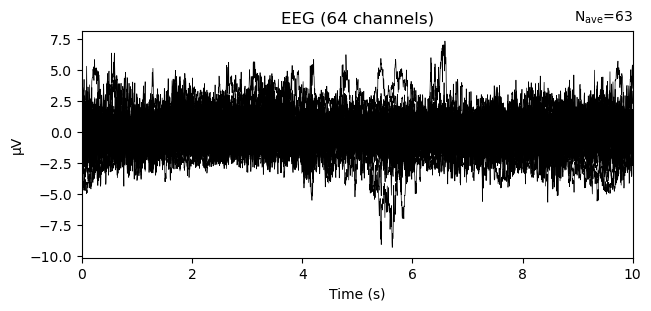

In [36]:
calc_evoked(epochs[0]).plot(time_unit="s");

    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 63
[done]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 1.5e-13 (2.2e-16 eps * 64 dim * 10  max singular value)
    Estimated rank (eeg): 62
    EEG: rank 62 computed from 64 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank={'eeg': 62}
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 62 (2 small eigenvalues omitted)


/mnt/data1/EEG_DATA/ds003969/navnoorIntern/ipykernel_4116/1642282608.py:3: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  noise_cov = mne.compute_covariance(epoch, tmax=0., method='empirical')
/mnt/data1/EEG_DATA/ds003969/navnoorIntern/ipykernel_4116/1642282608.py:3: RuntimeWarning: Too few samples (required : 325 got : 63), covariance estimate may be unreliable
  noise_cov = mne.compute_covariance(epoch, tmax=0., method='empirical')


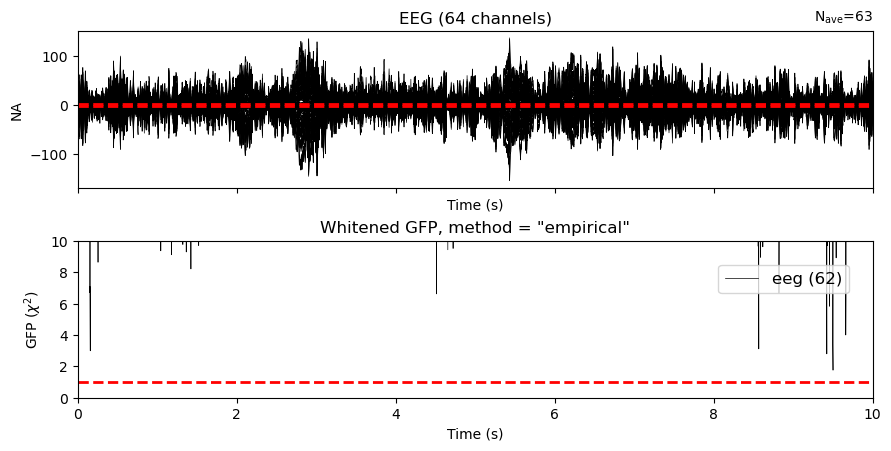

In [37]:
calc_evoked(epochs[0]).plot_white(calc_noise_cov(epochs[0]), time_unit="s");

In [54]:
def calc_label_ts(epochs, inverse_operator, labels):
    method = "dSPM"
    snr = 3.0
    lambda2 = 1.0 / snr**2
    # Compute inverse solution and for each epoch
    stcs = mne.minimum_norm.apply_inverse_epochs(
        epochs, inverse_operator, lambda2, method, pick_ori="normal", return_generator=True
    )
    # Average the source estimates within each label using sign-flips to reduce
    # signal cancellations, also here we return a generator
    src = inverse_operator["src"]
    label_ts = mne.extract_label_time_course(
        stcs, labels, src, mode="mean_flip", return_generator=True
    )
    return label_ts

In [55]:
%%capture

def compute_connectivity_of_label_ts(epochs, inverse_operator, labels, fmin, fmax, sfreq, method):
    con = spectral_connectivity_epochs(
        calc_label_ts(epochs, inverse_operator, labels),
        method="pli",
        mode="multitaper",
        sfreq=sfreq,
        fmin=fmin,
        fmax=fmax,
        faverage=True,
        mt_adaptive=True,
        n_jobs=1 )
    return con


In [46]:
from mne.viz import circular_layout

from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle


In [62]:
%%capture

# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith("lh")]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + "rh" for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(
    label_names, node_order, start_pos=90, group_boundaries=[0, len(label_names) / 2]
)

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
conmat = []
for i in range(len(epochs)):
    conmat.append(compute_connectivity_of_label_ts(epochs[i], calc_inverse_operator(epochs[i], fwd[i], calc_noise_cov(epochs[i])), labels, fmin=8.0, fmax=13.0, sfreq=256.0, method="pli").get_data(output="dense")[:, :, 0])

<Figure size 640x480 with 0 Axes>

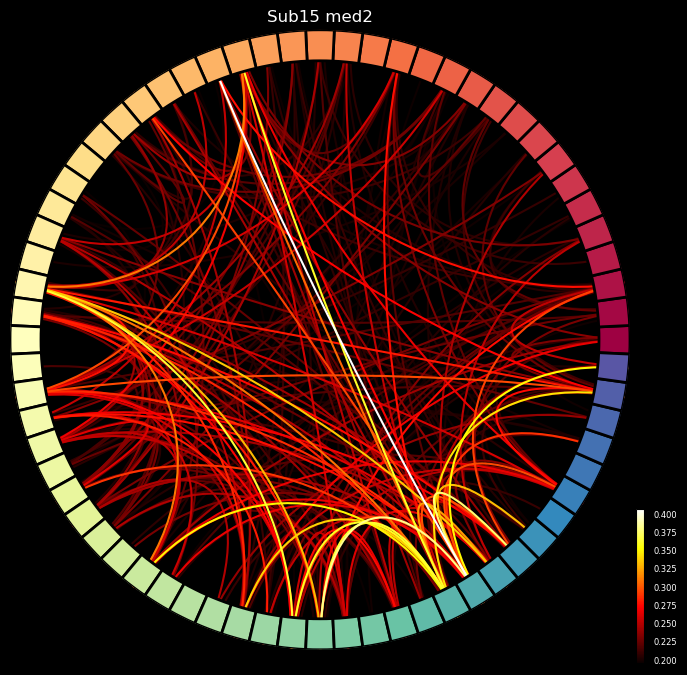

(<Figure size 1000x1000 with 2 Axes>,
 <PolarAxes: title={'center': 'Sub15 med2'}>)

In [175]:
plt.clf();
no_names = [""] * len(label_names)

fig, ax = plt.subplots(figsize=(10,10), facecolor="black", subplot_kw=dict(polar=True))

plot_connectivity_circle(
    conmat[0],
    no_names,
    n_lines=300,
    title="Sub15 med2",
    padding=0,
    fontsize_colorbar=6,
    ax=ax,
)

In [176]:
from nilearn import plotting

/mnt/data1/EEG_DATA/ds003969/navnoorIntern/ipykernel_4116/2842190932.py:4: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  plotting.plot_connectome(conmat[0], region_coordinates, edge_threshold='99%', title='Connectome Plot', colorbar=True);
/mnt/data1/EEG_DATA/ds003969/navnoorIntern/ipykernel_4116/2842190932.py:5: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  plotting.plot_connectome(conmat[1], region_coordinates, edge_threshold='99%', title='Connectome Plot', colorbar=True);


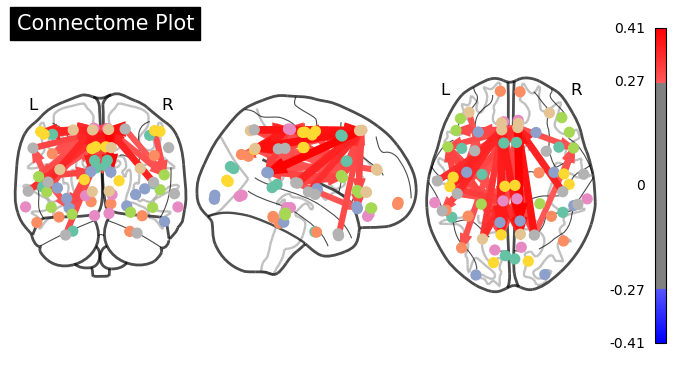

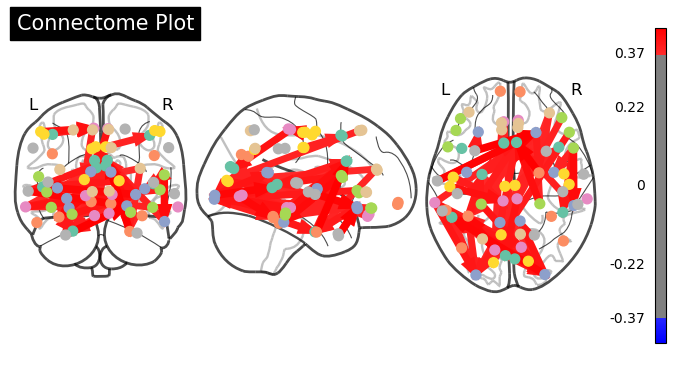

In [178]:
from nilearn import plotting

# Plotting the connectomechannel_locs]
plotting.plot_connectome(conmat[0], region_coordinates, edge_threshold='99%', title='Connectome Plot', colorbar=True);
plotting.plot_connectome(conmat[1], region_coordinates, edge_threshold='99%', title='Connectome Plot', colorbar=True);
plotting.show();

In [181]:
view = plotting.view_connectome(conmat[0], region_coordinates, edge_threshold="99%")
view
# 3d model won't be visible in github

In [182]:
view = plotting.view_connectome(conmat[1], region_coordinates, edge_threshold="99%")
view